In [1]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude"])

In [19]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        hidden_size = 48
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
#             nn.Dropout(0.03),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
#             nn.Dropout(0.5),
            nn.Linear(hidden_size, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                            test_size=0.2, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it
grad_norms = []

def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm


In [ ]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=9e-3,
    weight_decay=5e-2
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999999, 
    patience=10, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    grad_norm = 0
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        grad_norm += get_gradient_norm(model)
        optimizer.step()

        running_loss += loss.item()
        
    grad_norms.append(grad_norm / len(train_loader))
    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        tl = f"Training Loss: {int(train_losses[-1])}"
        vl = f"Validation Loss: {int(val_losses[-1])}"
        l1 = f"L1: {int(l1_mean_loss)}"
        dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
        print(dl)

Epoch 1, Training Loss: 240692, Validation Loss: 246775, 11.484246614509658
Epoch 101, Training Loss: 57752, Validation Loss: 99171, 153034.5628056057
Epoch 201, Training Loss: 52702, Validation Loss: 71112, 205421.57840483662
Epoch 301, Training Loss: 52031, Validation Loss: 74352, 277257.5967465402
Epoch 401, Training Loss: 53271, Validation Loss: 76641, 274749.9623102167
Epoch 501, Training Loss: 52581, Validation Loss: 53912, 231613.9127814402
Epoch 601, Training Loss: 50696, Validation Loss: 67203, 220317.9968240783
Epoch 701, Training Loss: 52925, Validation Loss: 53046, 209632.0237298026
Epoch 801, Training Loss: 52316, Validation Loss: 90476, 220085.34443614623
Epoch 901, Training Loss: 51995, Validation Loss: 61053, 235606.84372133575
Epoch 1001, Training Loss: 50858, Validation Loss: 56168, 161824.68324576318
Epoch 1101, Training Loss: 48983, Validation Loss: 55330, 225663.9791615112
Epoch 1201, Training Loss: 50966, Validation Loss: 52473, 241871.0537533313
Epoch 1301, Train

Epoch 10701, Training Loss: 44733, Validation Loss: 108600, 229962.94344057926
Epoch 10801, Training Loss: 44012, Validation Loss: 50592, 235186.3394286825
Epoch 10901, Training Loss: 43930, Validation Loss: 54253, 193629.50587135006
Epoch 11001, Training Loss: 47185, Validation Loss: 146685, 243007.38873447943
Epoch 11101, Training Loss: 44586, Validation Loss: 50079, 282203.5016780222
Epoch 11201, Training Loss: 43326, Validation Loss: 60495, 154976.8099915108
Epoch 11301, Training Loss: 42919, Validation Loss: 51721, 223706.9180876914
Epoch 11401, Training Loss: 45733, Validation Loss: 67736, 224050.7270845817
Epoch 11501, Training Loss: 44402, Validation Loss: 50701, 223499.64999299226
Epoch 11601, Training Loss: 44202, Validation Loss: 53435, 212897.05489301204
Epoch 11701, Training Loss: 44398, Validation Loss: 51329, 206623.84044466124
Epoch 11801, Training Loss: 44940, Validation Loss: 55124, 233021.4939041131
Epoch 11901, Training Loss: 43994, Validation Loss: 62424, 197544.05

Epoch 21301, Training Loss: 42879, Validation Loss: 52606, 218820.48884386788
Epoch 21401, Training Loss: 42222, Validation Loss: 53998, 212618.57867517087
Epoch 21501, Training Loss: 43135, Validation Loss: 54690, 181391.29618303955
Epoch 21601, Training Loss: 40541, Validation Loss: 52798, 194042.14530987327
Epoch 21701, Training Loss: 43405, Validation Loss: 56394, 158881.99625812226
Epoch 21801, Training Loss: 43082, Validation Loss: 75574, 181351.1749964206
Epoch 21901, Training Loss: 42179, Validation Loss: 73242, 196857.70386267235
Epoch 22001, Training Loss: 40591, Validation Loss: 53774, 168912.42859219722
Epoch 22101, Training Loss: 42029, Validation Loss: 60206, 219987.84137407923
Epoch 22201, Training Loss: 43466, Validation Loss: 64145, 214929.15995188503
Epoch 22301, Training Loss: 42279, Validation Loss: 54441, 189358.2437444815
Epoch 22401, Training Loss: 43381, Validation Loss: 66542, 196807.72102234812
Epoch 22501, Training Loss: 43243, Validation Loss: 57149, 204153.

Epoch 31901, Training Loss: 39163, Validation Loss: 55113, 189550.5086297885
Epoch 32001, Training Loss: 39015, Validation Loss: 49848, 190029.40317975904
Epoch 32101, Training Loss: 40453, Validation Loss: 53536, 198113.61002740916
Epoch 32201, Training Loss: 37465, Validation Loss: 57707, 242700.5461383691
Epoch 32301, Training Loss: 37344, Validation Loss: 51654, 198106.20480008432
Epoch 32401, Training Loss: 36950, Validation Loss: 51158, 192471.38519710457
Epoch 32501, Training Loss: 39824, Validation Loss: 82910, 265541.16963347007
Epoch 32601, Training Loss: 39232, Validation Loss: 53319, 224406.07843868367
Epoch 32701, Training Loss: 37148, Validation Loss: 60198, 217024.16866326937
Epoch 32801, Training Loss: 37803, Validation Loss: 49296, 232985.1017956593
Epoch 32901, Training Loss: 40834, Validation Loss: 69723, 193205.70889528215
Epoch 33001, Training Loss: 38824, Validation Loss: 53060, 188787.90726184958
Epoch 33101, Training Loss: 38070, Validation Loss: 49809, 223553.5

Epoch 42501, Training Loss: 36743, Validation Loss: 53130, 195074.19021144425
Epoch 42601, Training Loss: 35823, Validation Loss: 49707, 233555.4873520833
Epoch 42701, Training Loss: 36792, Validation Loss: 49346, 242546.77031250333
Epoch 42801, Training Loss: 36265, Validation Loss: 52174, 182979.92012849674
Epoch 42901, Training Loss: 35987, Validation Loss: 80399, 195344.34261830014
Epoch 43001, Training Loss: 39927, Validation Loss: 51773, 250387.6286066453
Epoch 43101, Training Loss: 36488, Validation Loss: 48677, 175110.9149072142
Epoch 43201, Training Loss: 37026, Validation Loss: 48959, 208842.17700282388
Epoch 43301, Training Loss: 37224, Validation Loss: 48139, 213107.45904718002
Epoch 43401, Training Loss: 37098, Validation Loss: 55932, 179506.36358052003
Epoch 43501, Training Loss: 36112, Validation Loss: 49642, 194577.74130584928
Epoch 43601, Training Loss: 34970, Validation Loss: 59880, 209248.76611381513
Epoch 43701, Training Loss: 36745, Validation Loss: 62763, 219289.7

Epoch 53101, Training Loss: 37300, Validation Loss: 50696, 234721.26835054214
Epoch 53201, Training Loss: 39021, Validation Loss: 72184, 200331.04483362057
Epoch 53301, Training Loss: 35206, Validation Loss: 54801, 198060.07294781445
Epoch 53401, Training Loss: 35299, Validation Loss: 55108, 216695.7263244261
Epoch 53501, Training Loss: 36331, Validation Loss: 50771, 247655.02506031014
Epoch 53601, Training Loss: 36795, Validation Loss: 48966, 221903.56285567232
Epoch 53701, Training Loss: 36181, Validation Loss: 52945, 198673.32162501648
Epoch 53801, Training Loss: 36094, Validation Loss: 46547, 233511.30308534202
Epoch 53901, Training Loss: 34833, Validation Loss: 64202, 196051.72738958852
Epoch 54001, Training Loss: 34978, Validation Loss: 55743, 196177.7976378568
Epoch 54101, Training Loss: 33771, Validation Loss: 53167, 198937.63138023193
Epoch 54201, Training Loss: 35755, Validation Loss: 49835, 208366.50051385214
Epoch 54301, Training Loss: 35885, Validation Loss: 50118, 181551.

Epoch 63701, Training Loss: 33714, Validation Loss: 49332, 175771.44943534804
Epoch 63801, Training Loss: 35678, Validation Loss: 63406, 205725.79511012547
Epoch 63901, Training Loss: 36042, Validation Loss: 49354, 161106.3901559714
Epoch 64001, Training Loss: 33828, Validation Loss: 73969, 202296.68114008673
Epoch 64101, Training Loss: 35894, Validation Loss: 60819, 218370.24326131624
Epoch 64201, Training Loss: 36006, Validation Loss: 53855, 181567.42357295295
Epoch 64301, Training Loss: 35496, Validation Loss: 48421, 195690.65113842717
Epoch 64401, Training Loss: 34816, Validation Loss: 52423, 236176.4783582608
Epoch 64501, Training Loss: 35773, Validation Loss: 52410, 215519.57148270184
Epoch 64601, Training Loss: 36320, Validation Loss: 79813, 213447.05717312146
Epoch 64701, Training Loss: 38020, Validation Loss: 55399, 219165.5287299334
Epoch 64801, Training Loss: 38586, Validation Loss: 47499, 226851.6388218597
Epoch 64901, Training Loss: 35832, Validation Loss: 57128, 196175.47

Epoch 74301, Training Loss: 35229, Validation Loss: 87961, 188899.76251329193
Epoch 74401, Training Loss: 36002, Validation Loss: 49424, 181575.80207440504
Epoch 74501, Training Loss: 36065, Validation Loss: 54748, 229076.85754659332
Epoch 74601, Training Loss: 34715, Validation Loss: 66702, 191233.6623499143
Epoch 74701, Training Loss: 35710, Validation Loss: 51345, 212069.98909472112
Epoch 74801, Training Loss: 34113, Validation Loss: 85377, 195611.9466261235
Epoch 74901, Training Loss: 35737, Validation Loss: 89008, 192456.23038455963
Epoch 75001, Training Loss: 35776, Validation Loss: 52226, 217772.17422725365
Epoch 75101, Training Loss: 34942, Validation Loss: 50213, 182260.8109508294
Epoch 75201, Training Loss: 35070, Validation Loss: 52435, 202657.81725905082
Epoch 75301, Training Loss: 36244, Validation Loss: 67106, 188014.3927322485
Epoch 75401, Training Loss: 33932, Validation Loss: 70121, 195829.02073790526
Epoch 75501, Training Loss: 36595, Validation Loss: 86275, 229895.09

Epoch 84901, Training Loss: 35310, Validation Loss: 54461, 260818.94733146136
Epoch 85001, Training Loss: 34949, Validation Loss: 50169, 197598.0610684087
Epoch 85101, Training Loss: 35325, Validation Loss: 55861, 198286.0704590968
Epoch 85201, Training Loss: 33290, Validation Loss: 50870, 184647.1153730302
Epoch 85301, Training Loss: 35365, Validation Loss: 61251, 185706.42007498676
Epoch 85401, Training Loss: 34041, Validation Loss: 59331, 191721.3345840325
Epoch 85501, Training Loss: 35906, Validation Loss: 53400, 223978.08735841908
Epoch 85601, Training Loss: 34211, Validation Loss: 52307, 193464.95016932467
Epoch 85701, Training Loss: 35277, Validation Loss: 49927, 211059.6985693467
Epoch 85801, Training Loss: 36250, Validation Loss: 51501, 225863.26154748994
Epoch 85901, Training Loss: 35668, Validation Loss: 75300, 223000.45646838986
Epoch 86001, Training Loss: 35170, Validation Loss: 71724, 193753.01195548082
Epoch 86101, Training Loss: 35331, Validation Loss: 50260, 177820.998

Epoch 95501, Training Loss: 35223, Validation Loss: 49553, 225920.60206036558
Epoch 95601, Training Loss: 36167, Validation Loss: 51639, 169464.88888962648
Epoch 95701, Training Loss: 35687, Validation Loss: 61891, 233756.33090064584
Epoch 95801, Training Loss: 34085, Validation Loss: 61005, 220893.22390617186
Epoch 95901, Training Loss: 33415, Validation Loss: 53016, 177760.61219623467
Epoch 96001, Training Loss: 35626, Validation Loss: 55554, 221697.47729722506
Epoch 96101, Training Loss: 35321, Validation Loss: 57589, 199127.76514231614
Epoch 96201, Training Loss: 34252, Validation Loss: 49340, 190916.41706485368
Epoch 96301, Training Loss: 33154, Validation Loss: 50919, 146533.41631487917
Epoch 96401, Training Loss: 34545, Validation Loss: 60286, 220010.61627879972
Epoch 96501, Training Loss: 34824, Validation Loss: 49918, 210265.69975283733
Epoch 96601, Training Loss: 32032, Validation Loss: 55855, 200515.2585871661
Epoch 96701, Training Loss: 36206, Validation Loss: 64710, 184265

Epoch 106001, Training Loss: 33268, Validation Loss: 48544, 233430.94895236185
Epoch 106101, Training Loss: 34801, Validation Loss: 57742, 206417.30535358048
Epoch 106201, Training Loss: 33888, Validation Loss: 52051, 161460.61696544118
Epoch 106301, Training Loss: 32057, Validation Loss: 49009, 183039.67671654452
Epoch 106401, Training Loss: 35635, Validation Loss: 54729, 177219.63001113702
Epoch 106501, Training Loss: 34815, Validation Loss: 49234, 198862.88140236904
Epoch 106601, Training Loss: 35583, Validation Loss: 53812, 222814.32126069572
Epoch 106701, Training Loss: 35081, Validation Loss: 51890, 210201.85685546172
Epoch 106801, Training Loss: 34176, Validation Loss: 57173, 235625.336736485
Epoch 106901, Training Loss: 33029, Validation Loss: 51657, 180536.9887629142
Epoch 107001, Training Loss: 35675, Validation Loss: 54077, 250139.6300753487
Epoch 107101, Training Loss: 35695, Validation Loss: 74594, 268936.1684495662
Epoch 107201, Training Loss: 37064, Validation Loss: 6961

Epoch 116501, Training Loss: 36849, Validation Loss: 54274, 232115.5989813667
Epoch 116601, Training Loss: 33919, Validation Loss: 49612, 235085.77562167632
Epoch 116701, Training Loss: 32865, Validation Loss: 62304, 215061.47559849007
Epoch 116801, Training Loss: 33747, Validation Loss: 49654, 231600.75356514708
Epoch 116901, Training Loss: 34060, Validation Loss: 54502, 222751.34546487895
Epoch 117001, Training Loss: 34324, Validation Loss: 52128, 200184.0104416648
Epoch 117101, Training Loss: 33528, Validation Loss: 50935, 186518.3904828824
Epoch 117201, Training Loss: 34056, Validation Loss: 52537, 210384.83554085458
Epoch 117301, Training Loss: 35661, Validation Loss: 53115, 214546.01407588148
Epoch 117401, Training Loss: 34904, Validation Loss: 53910, 228183.0455186673
Epoch 117501, Training Loss: 35094, Validation Loss: 50809, 190689.05633572862
Epoch 117601, Training Loss: 33775, Validation Loss: 55265, 224291.64403821153
Epoch 117701, Training Loss: 34523, Validation Loss: 717

Epoch 127001, Training Loss: 34920, Validation Loss: 50584, 227511.4736554393
Epoch 127101, Training Loss: 34960, Validation Loss: 50825, 205245.28450301162
Epoch 127201, Training Loss: 33256, Validation Loss: 53828, 172070.14504193587
Epoch 127301, Training Loss: 33916, Validation Loss: 59817, 237933.09488403748
Epoch 127401, Training Loss: 33157, Validation Loss: 49703, 188197.42259637997
Epoch 127501, Training Loss: 34617, Validation Loss: 73886, 173579.00866857215
Epoch 127601, Training Loss: 34225, Validation Loss: 52927, 186077.16336540773
Epoch 127701, Training Loss: 32786, Validation Loss: 51289, 186099.59111409402
Epoch 127801, Training Loss: 33244, Validation Loss: 51257, 177259.54086530374
Epoch 127901, Training Loss: 34540, Validation Loss: 52102, 154298.09197367492
Epoch 128001, Training Loss: 34022, Validation Loss: 53407, 183236.0658131789
Epoch 128101, Training Loss: 34546, Validation Loss: 64759, 219966.29517404953
Epoch 128201, Training Loss: 33451, Validation Loss: 5

Epoch 137501, Training Loss: 33575, Validation Loss: 50007, 209253.34245677607
Epoch 137601, Training Loss: 35758, Validation Loss: 53878, 188532.67871116733
Epoch 137701, Training Loss: 34550, Validation Loss: 65035, 173970.69003876683
Epoch 137801, Training Loss: 32986, Validation Loss: 51675, 232065.98402240267
Epoch 137901, Training Loss: 33873, Validation Loss: 53215, 167842.32360416776
Epoch 138001, Training Loss: 33545, Validation Loss: 68774, 228382.4108516442
Epoch 138101, Training Loss: 35821, Validation Loss: 55683, 246572.173452917
Epoch 138201, Training Loss: 33456, Validation Loss: 52084, 239788.11373220303
Epoch 138301, Training Loss: 32971, Validation Loss: 56721, 208039.80387694997
Epoch 138401, Training Loss: 34955, Validation Loss: 70228, 221252.19045163944
Epoch 138501, Training Loss: 33547, Validation Loss: 53832, 203387.6118073462
Epoch 138601, Training Loss: 32427, Validation Loss: 51534, 167722.3359234381
Epoch 138701, Training Loss: 32190, Validation Loss: 9013

Epoch 148001, Training Loss: 35514, Validation Loss: 57265, 190863.87563559576
Epoch 148101, Training Loss: 36825, Validation Loss: 52835, 250369.36363864038
Epoch 148201, Training Loss: 32447, Validation Loss: 53708, 168345.325380003
Epoch 148301, Training Loss: 33601, Validation Loss: 53570, 203336.76194429814
Epoch 148401, Training Loss: 37964, Validation Loss: 52046, 188003.2118392746
Epoch 148501, Training Loss: 33881, Validation Loss: 51380, 275218.96591611503
Epoch 148601, Training Loss: 33421, Validation Loss: 53875, 219444.92470594685
Epoch 148701, Training Loss: 33431, Validation Loss: 71812, 192456.43380183153
Epoch 148801, Training Loss: 34151, Validation Loss: 57949, 174878.2484135231
Epoch 148901, Training Loss: 34185, Validation Loss: 60962, 205473.86978105226
Epoch 149001, Training Loss: 33958, Validation Loss: 58428, 198263.89113661845
Epoch 149101, Training Loss: 34718, Validation Loss: 52703, 243039.8578310973
Epoch 149201, Training Loss: 32964, Validation Loss: 6751

Epoch 158501, Training Loss: 32653, Validation Loss: 52143, 147038.6450810734
Epoch 158601, Training Loss: 33835, Validation Loss: 55363, 188780.71978873652
Epoch 158701, Training Loss: 33563, Validation Loss: 54594, 211636.83162037792
Epoch 158801, Training Loss: 31650, Validation Loss: 68019, 194712.20962391575
Epoch 158901, Training Loss: 32842, Validation Loss: 49227, 192157.73627235446
Epoch 159001, Training Loss: 34670, Validation Loss: 72933, 218358.4822329407
Epoch 159101, Training Loss: 32700, Validation Loss: 49199, 232676.94877664605
Epoch 159201, Training Loss: 33803, Validation Loss: 55999, 183187.9594460811
Epoch 159301, Training Loss: 32179, Validation Loss: 54377, 208256.9504820206
Epoch 159401, Training Loss: 32923, Validation Loss: 59898, 190678.03265025828
Epoch 159501, Training Loss: 33771, Validation Loss: 50306, 179583.67709146472
Epoch 159601, Training Loss: 34565, Validation Loss: 59718, 277850.54974593845
Epoch 159701, Training Loss: 33799, Validation Loss: 521

Epoch 169001, Training Loss: 44102, Validation Loss: 62450, 52376.843470201326
Epoch 169101, Training Loss: 42383, Validation Loss: 59148, 59236.7442118829
Epoch 169201, Training Loss: 42075, Validation Loss: 60270, 63789.703216805334
Epoch 169301, Training Loss: 41917, Validation Loss: 55866, 66653.34109548676
Epoch 169401, Training Loss: 41943, Validation Loss: 59434, 70410.87929628642
Epoch 169501, Training Loss: 41278, Validation Loss: 58101, 75139.20701657278
Epoch 169601, Training Loss: 41042, Validation Loss: 57996, 97519.82216370938
Epoch 169701, Training Loss: 39984, Validation Loss: 55346, 99590.10239590384
Epoch 169801, Training Loss: 38166, Validation Loss: 88655, 160012.7287487977
Epoch 169901, Training Loss: 36013, Validation Loss: 56855, 120128.19842855299
Epoch 170001, Training Loss: 37411, Validation Loss: 57721, 158531.87641890856
Epoch 170101, Training Loss: 37344, Validation Loss: 48954, 139526.52444783415
Epoch 170201, Training Loss: 39147, Validation Loss: 62129, 

Epoch 179501, Training Loss: 34901, Validation Loss: 48794, 154879.88329531605
Epoch 179601, Training Loss: 33392, Validation Loss: 56535, 179447.87926718997
Epoch 179701, Training Loss: 33694, Validation Loss: 55780, 197476.1894371527
Epoch 179801, Training Loss: 34689, Validation Loss: 56152, 233739.55658490106
Epoch 179901, Training Loss: 32424, Validation Loss: 52723, 167070.24594891287
Epoch 180001, Training Loss: 31211, Validation Loss: 50411, 156740.06501374487
Epoch 180101, Training Loss: 35852, Validation Loss: 52225, 172357.79820523196
Epoch 180201, Training Loss: 32737, Validation Loss: 52620, 194945.49014862478
Epoch 180301, Training Loss: 33299, Validation Loss: 48088, 199905.64560959744
Epoch 180401, Training Loss: 32783, Validation Loss: 51584, 184217.96661485356
Epoch 180501, Training Loss: 34392, Validation Loss: 61509, 218287.7529447143
Epoch 180601, Training Loss: 34066, Validation Loss: 53445, 171059.97002020842
Epoch 180701, Training Loss: 34060, Validation Loss: 6

Epoch 190001, Training Loss: 32543, Validation Loss: 56792, 176250.7817827513
Epoch 190101, Training Loss: 34646, Validation Loss: 54231, 160854.00460294378
Epoch 190201, Training Loss: 31774, Validation Loss: 53876, 175197.93339162195
Epoch 190301, Training Loss: 33150, Validation Loss: 56851, 206577.1401224857
Epoch 190401, Training Loss: 33046, Validation Loss: 62362, 156279.41322015572
Epoch 190501, Training Loss: 32058, Validation Loss: 49927, 234169.9648817062
Epoch 190601, Training Loss: 35205, Validation Loss: 51813, 178873.42739505615
Epoch 190701, Training Loss: 36454, Validation Loss: 75074, 227376.6230634288
Epoch 190801, Training Loss: 31988, Validation Loss: 54334, 180500.5199737586
Epoch 190901, Training Loss: 33140, Validation Loss: 50513, 182092.05231007337
Epoch 191001, Training Loss: 34377, Validation Loss: 54785, 183537.76919264148
Epoch 191101, Training Loss: 33113, Validation Loss: 66013, 169492.39997985202
Epoch 191201, Training Loss: 36385, Validation Loss: 5149

Epoch 200501, Training Loss: 33476, Validation Loss: 53100, 163680.2125626074
Epoch 200601, Training Loss: 33966, Validation Loss: 51667, 198997.2902939724
Epoch 200701, Training Loss: 32100, Validation Loss: 50332, 202539.86302876985
Epoch 200801, Training Loss: 32731, Validation Loss: 67540, 227665.16905004092
Epoch 200901, Training Loss: 32640, Validation Loss: 51682, 221030.95935145972
Epoch 201001, Training Loss: 34851, Validation Loss: 68247, 200864.46964381696
Epoch 201101, Training Loss: 33959, Validation Loss: 50751, 193061.41975422323
Epoch 201201, Training Loss: 32605, Validation Loss: 55202, 183081.25777470984
Epoch 201301, Training Loss: 33444, Validation Loss: 52309, 167728.57183122408
Epoch 201401, Training Loss: 34127, Validation Loss: 51950, 185850.88924502756
Epoch 201501, Training Loss: 30965, Validation Loss: 53728, 186371.46420755793
Epoch 201601, Training Loss: 33390, Validation Loss: 54949, 212168.56577920704
Epoch 201701, Training Loss: 33437, Validation Loss: 5

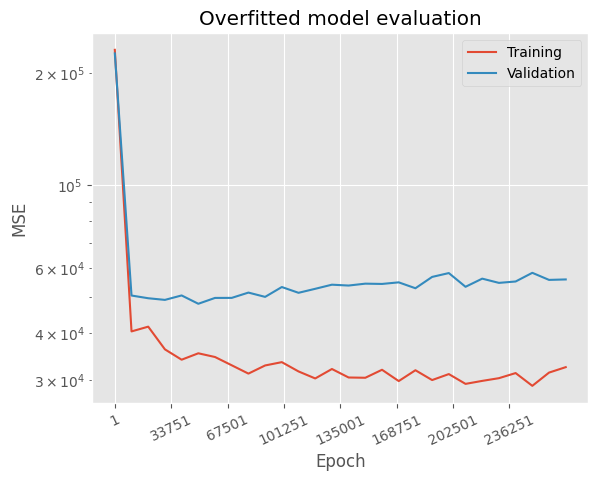

In [6]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.style.use("ggplot")
plt.title("Overfitted model evaluation")


# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
# plt.savefig("../visualizations/overfit_model_evaluation_full_dataset.png", dpi=800)

# Saving. Good results

In [ ]:
# class TabularFFNNSimple(nn.Module):
#     def __init__(self, input_size, output_size, dropout_prob=0.4):
#         super(TabularFFNNSimple, self).__init__()
#         hidden_size = 48
#         self.ffnn = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
# #             nn.BatchNorm1d(hidden_size),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, output_size)
#         )
        
#         for m in self.ffnn:
#             if isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)
#                 m.bias.data.fill_(0)

#     def forward(self, x):
#         x = x.float()
#         # print(x)
#         x = x.view(x.size(0), -1)
#         x = self.ffnn(x)
#         return x
    
# # Split the data into features and target
# X = data.drop('price', axis=1)
# y = data['price']

# # Standardize the features
# device = torch.device("cpu")
# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
# y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# # Split the data into training and combined validation and testing sets
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
#                                                             test_size=0.4, random_state=42)

# # Split the combined validation and testing sets
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# # Create DataLoader for training, validation, and testing
# train_data = TensorDataset(X_train, y_train)
# val_data = TensorDataset(X_val, y_val)
# test_data = TensorDataset(X_test, y_test)

# batch_size = 256
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # Check if the dimensions match the expected input size for the model
# input_size = X_train.shape[1]

# # Output
# # input_size, train_loader, test_loader

# model = TabularFFNNSimple(
#     input_size = input_size,
#     output_size = 1
# )
# model.to(device)

# num_epochs = 300000
# train_losses = []
# val_losses = []
# epochs_suc = [] # to have a reference to it
# grad_norms = []

# def get_gradient_norm(model):
#     total_norm = 0
#     for p in model.parameters():
#         if p.grad is not None:
#             param_norm = p.grad.data.norm(2)
#             total_norm += param_norm.item() ** 2
#     total_norm = total_norm ** 0.5
#     return total_norm

# optimizer = optim.Adam(
#     model.parameters(), 
#     lr=9e-3,
#     weight_decay=1e-4
# )
# criterion = torch.nn.MSELoss()
# criterion_abs = torch.nn.L1Loss()
# criterion = criterion_abs

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.999999, 
#     patience=10, 
#     verbose=True
# )

# for epoch in range(num_epochs):
#     # Training
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     l1_losses = []
#     grad_norm = 0
#     for tuple_ in train_loader:
#         datas, prices = tuple_
#         optimizer.zero_grad()
#         outputs = model(datas)
#         prices_viewed = prices.view(-1, 1).float()
#         loss = criterion(outputs, prices_viewed)
#         loss.backward()
#         grad_norm += get_gradient_norm(model)
#         optimizer.step()

#         running_loss += loss.item()
        
#     grad_norms.append(grad_norm / len(train_loader))
#     train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

#     # Validation
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation
#         for tuple_ in val_loader:
#             datas, prices = tuple_
#             outputs = model(datas)  # Forward pass
#             prices_viewed = prices.view(-1, 1).float()
#             loss = criterion(outputs, prices_viewed)  # Compute loss
#             val_loss += loss.item()  # Accumulate the loss
#             l1_losses.append(criterion_abs(outputs, prices_viewed))

#     val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
#     l1_mean_loss = sum(l1_losses) / len(l1_losses)
#     # Print epoch's summary
#     epochs_suc.append(epoch)
#     scheduler.step(val_losses[-1])
#     if epoch % 100 == 0:
#         tl = f"Training Loss: {int(train_losses[-1])}"
#         vl = f"Validation Loss: {int(val_losses[-1])}"
#         l1 = f"L1: {int(l1_mean_loss)}"
#         dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
#         print(dl)